# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Получим features и target 

In [5]:
features, target = next(train_gen_flow)

In [6]:
features.shape

(32, 224, 224, 3)

Датасет содержит 7591 фотографий размером 224х224, разделенные на 32 батча. 

Построим график распределения возраста. 

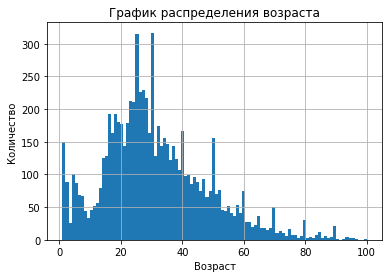

In [7]:
labels.hist(bins=100)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('График распределения возраста')
plt.show()

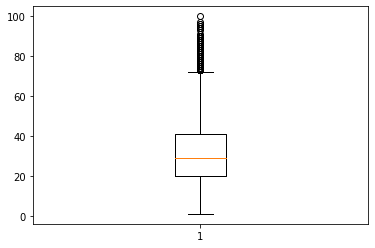

In [8]:
plt.boxplot(labels['real_age'])
plt.show()

In [9]:
print(labels.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


Похоже на нормальное распределение  с перекосом направо. Представлены данные по возрасту от 1 до 100 лет. Основная часть данных по возрасту приходится на возраст от 20 до 40 лет, со средним значением 31 год. В возрасте от 75 до 100 лет- единичные выбросы

На графике видны пики в возрасте 25, 30, 40, 50, 60, 70 лет. Это может быть связано с тем что точный возраст не был известен и его округляли до круглой цифры.

Посмотрим на фотографии. 

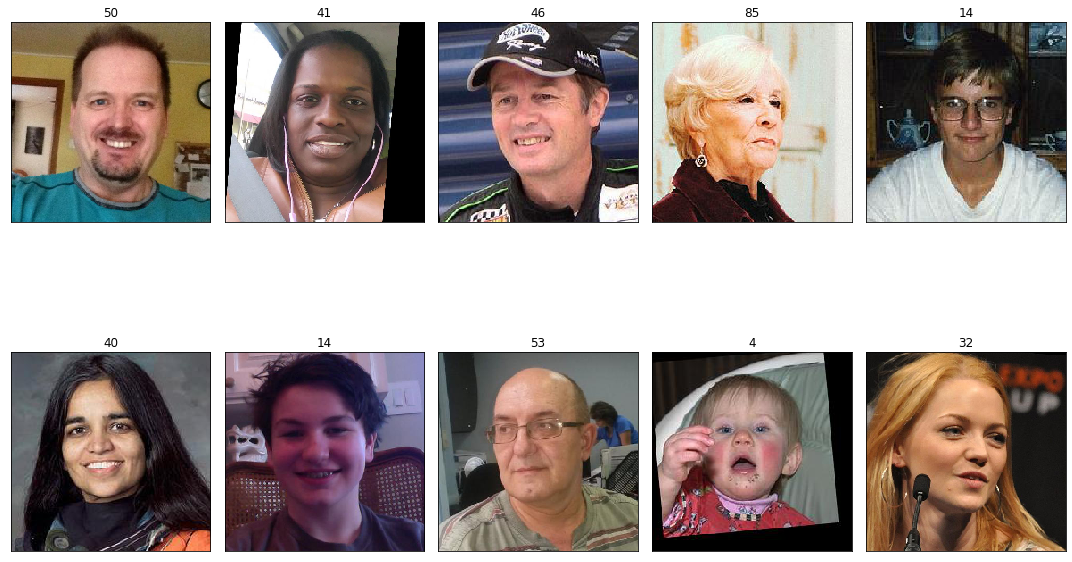

In [10]:
fig = plt.figure(figsize=(15,15))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i])
    plt.tight_layout()
    

В данных есть фотографии с небольшим наклоном, с недостаточной четкостью и освещением,  люди с бородой и посторонние предметы: очки, шапки\шляпы, руки и тд. Это может усложнить работу модели. Большинство фотографий представлены в нормальной цветовой гамме. 

Размер выборки не очень большой, но достаточный для обучения модели. Для обучающей выборки возьмем 75%, добавив аугментацию с  увеличенным вращением. Можно добавить параметр по добавлению фотографий с пониженой яркостью, тк есть фотографии с недостаточным освещением. Для тестовой выборки возьмем 25% и оставим ее без изменений. 

## Обучение модели

**Код Модели**

```python

import numpy as np
import pandas as pd
from tensorflow.keras.layers import  Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50 
 
 
def load_train(path):
    labels = pd.read_csv(path+'labels.csv')                                                     
    train_datagen = ImageDataGenerator(rescale= 1./255, horizontal_flip=True, validation_split=0.25)  
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42)
    return train_datagen_flow
 
def load_test(path):
    labels = pd.read_csv(path+'labels.csv')  
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)  
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation', 
        seed=42)
 
    return test_datagen_flow
 
def create_model(input_shape):
 
    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet', 
                    include_top= False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae']) 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

**Результат модели**

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 91s - loss: 196.5002 - mae: 10.5042 - val_loss: 522.2583 - val_mae: 17.6665
Epoch 2/10
178/178 - 36s - loss: 102.1091 - mae: 7.7129 - val_loss: 410.9897 - val_mae: 15.1797
Epoch 3/10
178/178 - 36s - loss: 63.2305 - mae: 6.1206 - val_loss: 313.2398 - val_mae: 13.0640
Epoch 4/10
178/178 - 36s - loss: 44.1863 - mae: 5.1333 - val_loss: 287.5573 - val_mae: 12.5585
Epoch 5/10
178/178 - 36s - loss: 31.3889 - mae: 4.2879 - val_loss: 104.3878 - val_mae: 7.7267
Epoch 6/10
178/178 - 36s - loss: 21.8898 - mae: 3.6393 - val_loss: 86.4221 - val_mae: 6.9539
Epoch 7/10
178/178 - 36s - loss: 16.9695 - mae: 3.1523 - val_loss: 107.5474 - val_mae: 7.8839
Epoch 8/10
178/178 - 36s - loss: 12.3142 - mae: 2.7130 - val_loss: 80.5033 - val_mae: 6.8512
Epoch 9/10
178/178 - 36s - loss: 9.9829 - mae: 2.4159 - val_loss: 69.7886 - val_mae: 6.3681
Epoch 10/10
178/178 - 36s - loss: 8.2206 - mae: 2.2014 - val_loss: 70.8528 - val_mae: 6.4585

60/60 - 9s - loss: 70.8528 - mae: 6.4585
Test MAE: 6.4585



```

Модель построена на ResNet50. Наилучший результат MAE на тестовой выборке - 6.36 достигнут на 9 эпохе

## Анализ обученной модели

 В имеющемся датасете содержится 7591 фотографий размером 224х224, среди которых были фотографии со слабым освещением, с недостаточной четкостью и с вращением по горизонтали. Перед моделью была поставлена задача регрессии по определению возраста по фотографии и чтобы МАЕ было не выше 7.
 
 Для обучающей выборки взяли 75% с гиперпараметром horizontal_flip , а 25% оставили в тестовой выборке без изменений.
 
 Для обучения взяли предобученную нейронную сеть с архитектурой ResNet50 и дополнительно обучили ее на имеющихся данных. Использовался только 1 нейрон, который должен вернуть число-предсказание, с активацией relu, тк она отрицательные числа приводит к нулю (возраст отрицательным быть не может). Также использовали оптимизатор Adam с шагом обучения 0.0005. В качестве функции потерь использовался Mean Squared Error, тк она подходит для задач регрессии. 
 
 Протестировав модель с этими параметрами на 10 эпохах, достигли метрики МАЕ в 6.36 на 9 эпохе. На 10 эпохе МАЕ на обучающей выборке продолжает уменьшаться, но на тестовых данных увеличивается. Что может говорить о начале переобучения. Модель можно ограничить 9 эпохами.
 
 Модель обучена, метрика ниже таргета, те ее можно использовать. 